In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision.models import resnet50, resnet18

from cutmix.cutmix import CutMix
from cutmix.utils import CutMixCrossEntropyLoss
from d2l import torch as d2l

import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import KFold
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm

## Cancer detection
This project Will use histopathologic cancer dataset from Kaggle, and detect which image has the cancer

Let's get some idea of our data. First by looking at the image and label.

In [18]:
train_labels = pd.read_csv('train_labels.csv')
train_labels.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


id       f38a6374c348f90b587e046aac6079959adf3835
label                                           0
Name: 0, dtype: object


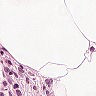

In [34]:
image_path = 'train/' + train_labels.loc[0]['id'] + '.tif'
print(train_labels.loc[0])
Image.open(image_path)


In [3]:
# let's see how many target label we have
train_labels = sorted(list(set(train_labels['label'])))
n_classes = len(train_labels)
print(n_classes)

2


#### we can see that we only have two classes, yes or no. So we will use sigmoid activation function instead of SoftMax function.

### Preprocessing image 
In order to have a consist input, we will preprocessing our image, resize, and normalize the image.

In [ ]:
pre_train_transform = transforms.Compose([
    transforms.Resize(96),
    transforms.CenterCrop(96),    
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

## dataset class
In order to use the neural network, we have to marge the image with the label. So we create the my_dataset class, that will return the image with its label. Also, using this class, we can easily modify our image.

In [4]:
# It is the preprocessing function, in our case we  only resize the image and do the normalization
# we want the do more preprocessing easily by changing the function below


#my dataset class
class my_dataset(Dataset):
    def __init__(self, csv_file, transform = pre_train_transform, prefix = ''):
        super(my_dataset, self).__init__()
        self.data = pd.read_csv(csv_file)
        
        self.prefix = prefix
        self.img = self.data['id']
        self.label = self.data['label']
        self.transform = transform
        self.length = len(self.label)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        path = self.prefix + self.img[idx] + '.tif'
        img = Image.open(path)
        img = self.transform(img)
        
        label = self.label[idx]
        number_label = label

        return img, number_label



### Setup the network
We will setup our network here. In our case, we will use ResNet18 and ResNet50. 

In [5]:
def resnest18_model(num_classes, pretrained = True, frozen_feature = False):
    model = resnet18(pretrained = pretrained)
    
    if frozen_feature:
        for param in model.parameters():
            param.requires_grad = False
    
    fc_in_feature = model.fc.in_features
    #model.fc = nn.Sequential(nn.Linear(fc_in_feature, num_classes))
    model.fc = nn.Sequential(nn.Linear(fc_in_feature, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid())

    return model

def resnest50_model(num_classes, pretrained = True, frozen_feature = False):
    model = resnet50(pretrained = pretrained)
    
    if frozen_feature:
        for param in model.parameters():
            param.requires_grad = False
    
    fc_in_feature = model.fc.in_features
    #model.fc = nn.Sequential(nn.Linear(fc_in_feature, num_classes))
    model.fc = nn.Sequential(nn.Linear(fc_in_feature, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid())

    return model

### CPU or GPU
we are using pytorch, and we can decide runing this program on cpu or gpu. 

In [6]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()
print(device)

cuda


### Training 
now, we will train the model, here is the training and validation function

In [7]:
def train(model, train_loader, epochs, loss_func, optimizer, scheduler = None):
    best_loss = 100
    for i in range(epochs):
        train_losses = []
        
        model.train()
        print(f'')
        for img, label in tqdm(train_loader):
            img = img.to(device)
            label = label.to(device).to(torch.float32)
            
            pred = model(img).ravel().to(torch.float32)
            loss = loss_func(pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            
        if scheduler != None:
            scheduler.step()
        loss = np.sum(train_losses) / len(train_losses)
        print(f'epochs {i+1} - loss {loss} ')
        
        if loss < best_loss:
            torch.save(model.state_dict(), f'./model_auto_save.pth')
            best_loss = loss
    
def train_val(train_loader, valid_loader = None):
    model = resnest18_model(2)
    model = model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=10)#T_max = 10
    
    train(model, train_loader, epochs, loss_func, optimizer, scheduler)
    
    torch.save(model.state_dict(), f'./model_resnet18.pth')
    print('--finish saving!--')
    
    model.eval()
    metric_valid = d2l.Accumulator(3)
    with torch.no_grad():
        for img, label in tqdm(valid_loader):
            img = img.to(device)
            label = label.to(device)
            
            pred = model(img)
            loss = loss_func(pred, label)
            acc = (pred.argmax(dim=-1) == label.to(device)).float().mean()
            metric_valid.add(loss * img.shape[0], d2l.accuracy(pred, label), img.shape[0])
            
    test_ls, test_acc   = metric_valid[0]/metric_valid[2], metric_valid[1]/metric_valid[2]
    print(f'validtion loss {test_ls:.6f}, acc {test_acc:.6f}')
    
def train_test(train_loader, test_loader, transform):
    model = resnest18_model(2)
    model = model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=10)#T_max = 10
    
    train(model, train_loader, epochs, loss_func, optimizer, scheduler)
    
    torch.save(model.state_dict(), f'./model_resnet18.pth')
    print('--finish saving!--')
    
    test_prediction = []
    model.eval()
    metric_valid = d2l.Accumulator(3)
    with torch.no_grad():
        for img_name in test_loader['id']:
            path = 'test/' + img_name + '.tif'
            img = Image.open(path)
            img = transform(img)            
            img = img.to(device)
            
            pred = model(img.unsqueeze(0))
            res = 0 if pred < 0.5 else 1
            test_prediction.append({'id':img_name, 'label':res})
    
    test_pd = pd.DataFrame(test_prediction)
    test_pd.to_csv('submission.csv',index=False)

### Train and validation
before we train our model, we need to select our hyperparameters and models structure. We can use kfold validation to find which models or hyperparameters are the best.

In [8]:
epochs = 10
batch_size = 32
learning_rate = 1e-4
weight_decay = 1e-3
#loss_func = nn.CrossEntropyLoss()  
loss_func = nn.BCELoss()
kfold = KFold(n_splits = 5, shuffle = True)

train_dataset = my_dataset('train_labels.csv', pre_train_transform, 'train/')

for train_ids,valid_ids in kfold.split(train_dataset):
    break
train_sample = torch.utils.data.SubsetRandomSampler(train_ids)
valid_sample = torch.utils.data.SubsetRandomSampler(valid_ids)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sample)
valid_loader = DataLoader(train_dataset, batch_size=32, sampler=valid_sample)
    
train_val(train_loader, valid_loader)


'\nfor train_ids,valid_ids in kfold.split(train_dataset):\n    break\ntrain_sample = torch.utils.data.SubsetRandomSampler(train_ids)\nvalid_sample = torch.utils.data.SubsetRandomSampler(valid_ids)\ntrain_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sample)\nvalid_loader = DataLoader(train_dataset, batch_size=32, sampler=valid_sample)\n    \ntrain_val(train_loader, valid_loader)\n'

### Final training and testing
After we choose the model and hyperparameters, we will train our model with all the training dataset, and predict the testing image. And we will store the prediction in 'submission.csv' file 

In our case we will use resnet18, for it is smaller and easier to train. Our training dataset is large, if we use resnet50, it will take more than one hour to train ten epochs. For efficiency we will use resnet18. 

In [9]:
train_data = DataLoader(train_dataset, batch_size=32)
test_csv = pd.read_csv('sample_submission.csv')
train_test(train_data, test_csv, pre_train_transform)

100%|██████████| 6876/6876 [06:30<00:00, 17.59it/s]


epochs 1 - loss 0.18453521039886828 



100%|██████████| 6876/6876 [06:02<00:00, 18.95it/s]


epochs 2 - loss 0.10056062949973864 



100%|██████████| 6876/6876 [05:31<00:00, 20.75it/s]


epochs 3 - loss 0.05700355861537468 



100%|██████████| 6876/6876 [05:24<00:00, 21.20it/s]


epochs 4 - loss 0.034056218072787754 



100%|██████████| 6876/6876 [05:18<00:00, 21.56it/s]


epochs 5 - loss 0.020203690250739578 



100%|██████████| 6876/6876 [06:04<00:00, 18.89it/s]


epochs 6 - loss 0.011532518366788437 



100%|██████████| 6876/6876 [06:39<00:00, 17.21it/s]


epochs 7 - loss 0.006509412476919419 



100%|██████████| 6876/6876 [06:44<00:00, 17.01it/s]


epochs 8 - loss 0.0025827572762777695 



100%|██████████| 6876/6876 [06:16<00:00, 18.27it/s]


epochs 9 - loss 0.0007580532260118858 



100%|██████████| 6876/6876 [06:05<00:00, 18.79it/s]


epochs 10 - loss 0.0001783413139660684 
--finish saving!--
